# Introduction

In this notebook, we analyze and forecast Indonesia’s GDP per Capita (Current USD) using a mix of time series modeling (SARIMAX) and machine learning (XGBoost).
The idea is to combine the strengths of both worlds:
- SARIMAX to capture temporal patterns and the effect of macroeconomic exogenous variables (inflation, unemployment, interest rate, etc.).
- XGBoost Regressor to leverage non-linear relationships and lagged features from the panel dataset.
The dataset covers annual macroeconomic indicators up to 2023. Our main goal is to evaluate model performance and generate short-term forecasts for the next few years (2024–2026).

In [1]:
# Imports & display config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# SARIMAX
import statsmodels.api as sm

# XGBoost
from xgboost import XGBRegressor

sns.set(style="whitegrid")
pd.set_option("display.float_format", "{:,.2f}".format)

In [2]:
# Load dataset
DATA_PATH = "../data/world_bank_data_2025.csv"
df = pd.read_csv(DATA_PATH)

# Basic hygiene
df.columns = [c.strip() for c in df.columns]
df['year'] = df['year'].astype(int)

print(df.shape)
df.head()

(3472, 16)


,country_name,country_id,year,Inflation (CPI %),GDP (Current USD),GDP per Capita (Current USD),Unemployment Rate (%),"Interest Rate (Real, %)","Inflation (GDP Deflator, %)",GDP Growth (% Annual),Current Account Balance (% GDP),Government Expense (% of GDP),Government Revenue (% of GDP),Tax Revenue (% of GDP),Gross National Income (USD),Public Debt (% of GDP)
0,Aruba,aw,2010,2.08,"2,453,597,206.70","24,093.14",NaN,11.67,-1.22,-2.73,-18.75,NaN,NaN,NaN,"2,313,385,195.53",NaN
1,Aruba,aw,2011,4.32,"2,637,859,217.88","25,712.38",NaN,4.80,4.01,3.37,-9.88,NaN,NaN,NaN,"2,391,841,396.65",NaN
2,Aruba,aw,2012,0.63,"2,615,208,379.89","25,119.67",NaN,8.20,0.18,-1.04,3.47,NaN,NaN,NaN,"2,499,117,877.09",NaN
3,Aruba,aw,2013,-2.37,"2,727,849,720.67","25,813.58",NaN,10.71,-2.00,6.43,-11.81,NaN,NaN,NaN,"2,563,517,262.57",NaN
4,Aruba,aw,2014,0.42,"2,790,849,720.67","26,129.84",NaN,3.21,3.96,-1.59,-4.66,NaN,NaN,NaN,"2,688,102,402.23",NaN


In [3]:
# Helpers
def latest_valid_year(dfx, col):
    """Return the most recent year where 'col' is non-null."""
    return dfx.dropna(subset=[col])['year'].max()

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid divide-by-zero
    denom = np.where(np.abs(y_true) < 1e-12, 1e-12, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom))

def safe_exogs(dfx, cols, min_non_null=6):
    """Keep exog columns with at least `min_non_null` non-nulls for the slice."""
    good = []
    for c in cols:
        if c in dfx.columns and dfx[c].notna().sum() >= min_non_null:
            good.append(c)
    return good

In [4]:
# Build single-country series & exog matrix (Indonesia)
country_id = "id"
target_col = "GDP per Capita (Current USD)"

candidate_exogs = [
    "Inflation (CPI %)",
    "Unemployment Rate (%)",
    "Interest Rate (Real, %)",
    "Current Account Balance (% GDP)",
    # add more if you want, but keep it lean for annual data
]

indo = df[df['country_id'] == country_id].copy()

# Which exogs actually have enough data?
exogs = safe_exogs(indo, candidate_exogs, min_non_null=6)
print("Exogenous used:", exogs)

# Align target & exogs, cut to latest valid target year
ymax = latest_valid_year(indo, target_col)
slice_cols = ['year', target_col] + exogs
sub = indo.loc[indo['year'] <= ymax, slice_cols].dropna()

# Make a proper time index to silence statsmodels warnings
sub = sub.sort_values('year')
sub.index = pd.to_datetime(sub['year'].astype(str))  # yearly stamps

y = sub[target_col].astype(float)
X = sub[exogs].astype(float) if exogs else None

print("Years:", int(sub['year'].min()), "->", int(sub['year'].max()))
display(sub.tail())

Exogenous used: ['Inflation (CPI %)', 'Unemployment Rate (%)', 'Interest Rate (Real, %)', 'Current Account Balance (% GDP)']
Years: 2010 -> 2023


,year,GDP per Capita (Current USD),Inflation (CPI %),Unemployment Rate (%),"Interest Rate (Real, %)",Current Account Balance (% GDP)
year,,,,,,
2019-01-01,2019,"4,106.95",3.03,3.59,8.63,-2.71
2020-01-01,2020,"3,853.70",1.92,4.25,9.99,-0.42
2021-01-01,2021,"4,287.17",1.56,3.83,2.75,0.30
2022-01-01,2022,"4,730.75",4.21,3.46,-0.96,1.00
2023-01-01,2023,"4,876.31",3.67,3.31,7.28,-0.15


In [5]:
# Cell 6: Train/test split by time 
train_end = 2019  # you can move this if needed
train_mask = sub['year'] <= train_end
test_mask  = sub['year'] >  train_end

y_train = y[train_mask]
y_test  = y[test_mask]

X_train = X[train_mask] if X is not None else None
X_test  = X[test_mask]  if X is not None else None

print(y_train.index.min(), "->", y_train.index.max(), "|", y_test.index.min(), "->", y_test.index.max())

2010-01-01 00:00:00 -> 2019-01-01 00:00:00 | 2020-01-01 00:00:00 -> 2023-01-01 00:00:00


In [6]:
# Cell 7: Small grid search for (p,d,q) 
import itertools
import warnings
warnings.filterwarnings("ignore")

orders = list(itertools.product([0,1,2],[0,1,2],[0,1,2]))
best = None

def fit_sarimax(y_tr, y_te, X_tr=None, X_te=None, order=(1,1,1)):
    model = sm.tsa.statespace.SARIMAX(
        endog=y_tr,
        exog=X_tr,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    fc = res.get_forecast(steps=len(y_te), exog=X_te).predicted_mean
    return mape(y_te, fc), res, fc

for od in orders:
    try:
        score, res, fc = fit_sarimax(y_train, y_test, X_train, X_test, order=od)
        if (best is None) or (score < best[0]):
            best = (score, od, res, fc)
    except Exception:
        pass

best_mape, best_order, best_res, best_fc = best
print(f"Best order: {best_order} | Test MAPE: {best_mape*100:.2f}%")

Best order: (0, 2, 0) | Test MAPE: 5.21%


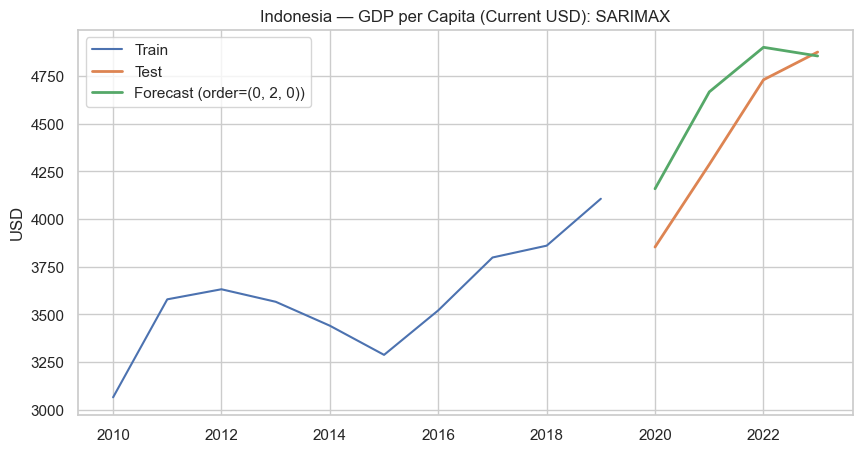

MAE: 219.23359374064648
MAPE: 5.206425460892696 %
R2  : 0.5833167201431206


In [7]:
# Cell 8: Final forecast, plot, diagnostics
plt.figure(figsize=(10,5))
plt.plot(y_train.index, y_train.values, label="Train")
plt.plot(y_test.index, y_test.values, label="Test", linewidth=2)
plt.plot(y_test.index, best_fc.values, label=f"Forecast (order={best_order})", linewidth=2)
plt.title("Indonesia — GDP per Capita (Current USD): SARIMAX")
plt.ylabel("USD")
plt.legend()
plt.show()

print("MAE:", mean_absolute_error(y_test, best_fc))
print("MAPE:", mape(y_test, best_fc)*100, "%")
print("R2  :", r2_score(y_test, best_fc))

In [8]:
# Feature list & panel base
target = "GDP per Capita (Current USD)"

# Choose compact, generally-available indicators
feat_base = [
    "Inflation (CPI %)",
    "Unemployment Rate (%)",
    "Interest Rate (Real, %)",
    "Current Account Balance (% GDP)",
    "Government Revenue (% of GDP)",
    "Government Expense (% of GDP)",
    "Tax Revenue (% of GDP)",
    "GDP Growth (% Annual)",
]

panel = df[['country_name','country_id','year',target] + feat_base].copy()
panel = panel.sort_values(['country_id','year'])

In [9]:
# Create lags & deltas by country
def add_lags_and_deltas(dfx, cols, group='country_id', n_lag=1):
    out = dfx.copy()
    g = out.groupby(group, group_keys=False)
    for c in cols:
        out[f"{c}_lag{n_lag}"] = g[c].shift(n_lag)
        out[f"{c}_chg{n_lag}"] = out[c] - out[f"{c}_lag{n_lag}"]
    return out

panel_feats = feat_base + [target]  # we also lag the target
panel_lag = add_lags_and_deltas(panel, panel_feats, n_lag=1)

# Drop rows that don't have lags
panel_lag = panel_lag.dropna(subset=[target]).reset_index(drop=True)

panel_lag.head()

,country_name,country_id,year,GDP per Capita (Current USD),Inflation (CPI %),Unemployment Rate (%),"Interest Rate (Real, %)",Current Account Balance (% GDP),Government Revenue (% of GDP),Government Expense (% of GDP),...,Government Revenue (% of GDP)_lag1,Government Revenue (% of GDP)_chg1,Government Expense (% of GDP)_lag1,Government Expense (% of GDP)_chg1,Tax Revenue (% of GDP)_lag1,Tax Revenue (% of GDP)_chg1,GDP Growth (% Annual)_lag1,GDP Growth (% Annual)_chg1,GDP per Capita (Current USD)_lag1,GDP per Capita (Current USD)_chg1
0,Andorra,ad,2010,"42,746.83",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andorra,ad,2011,"46,657.16",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.97,1.97,"42,746.83","3,910.33"
2,Andorra,ad,2012,"41,500.54",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.01,-4.97,"46,657.16","-5,156.61"
3,Andorra,ad,2013,"42,470.32",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.97,1.43,"41,500.54",969.77
4,Andorra,ad,2014,"44,369.66",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-3.55,6.05,"42,470.32","1,899.34"


In [10]:
# Train/test split by time (pooled)
train = panel_lag[panel_lag['year'] <= 2019].copy()
test  = panel_lag[panel_lag['year'] >  2019].copy()

# Feature columns = lags & changes + current exogs (optional)
lag_cols = [c for c in panel_lag.columns if c.endswith("_lag1") or c.endswith("_chg1")]
exog_cols = feat_base  # keep them too
features = lag_cols + exog_cols

X_train = train[features]
y_train = train[target]
X_test  = test[features]
y_test  = test[target]

print(X_train.shape, X_test.shape)

(2116, 26) (822, 26)


In [11]:
# Train XGBRegressor

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1
)
xgb.fit(X_train, y_train)

pred_test = xgb.predict(X_test)

print("XGB — MAE :", mean_absolute_error(y_test, pred_test))
print("XGB — MAPE:", mape(y_test, pred_test)*100, "%")
print("XGB — R2  :", r2_score(y_test, pred_test))

XGB — MAE : 1380.8959495182735
XGB — MAPE: 12.786679397517773 %
XGB — R2  : 0.9784213822298208


In [12]:
# Per-country evaluation table
test_eval = test[['country_id','country_name','year',target]].copy()
test_eval['pred'] = pred_test

agg = (test_eval
       .groupby(['country_id','country_name'], as_index=False)
       .apply(lambda g: pd.Series({
           'MAE': mean_absolute_error(g[target], g['pred']),
           'MAPE(%)': mape(g[target], g['pred'])*100,
           'R2': r2_score(g[target], g['pred']) if len(g)>=2 else np.nan
       }))
       .sort_values('MAPE(%)')
       .reset_index(drop=True))

display(agg.head(15))

,country_id,country_name,MAE,MAPE(%),R2
0,nc,New Caledonia,253.21,0.74,0.92
1,dk,Denmark,879.25,1.31,0.86
2,be,Belgium,722.32,1.37,0.91
3,mu,Mauritius,129.09,1.39,0.97
4,vc,St. Vincent and the Grenadines,137.04,1.39,0.95
5,de,Germany,701.93,1.43,0.86
6,kz,Kazakhstan,169.71,1.56,0.98
7,tr,Turkiye,180.87,1.60,0.98
8,nl,Netherlands,"1,056.67",1.69,0.86
9,pl,Poland,315.20,1.72,0.97


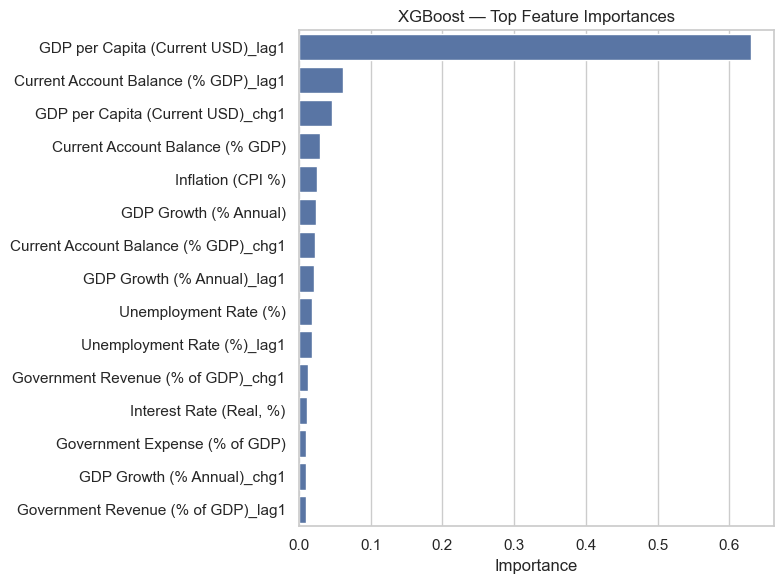

GDP per Capita (Current USD)_lag1      0.63
Current Account Balance (% GDP)_lag1   0.06
GDP per Capita (Current USD)_chg1      0.05
Current Account Balance (% GDP)        0.03
Inflation (CPI %)                      0.03
GDP Growth (% Annual)                  0.02
Current Account Balance (% GDP)_chg1   0.02
GDP Growth (% Annual)_lag1             0.02
Unemployment Rate (%)                  0.02
Unemployment Rate (%)_lag1             0.02
Government Revenue (% of GDP)_chg1     0.01
Interest Rate (Real, %)                0.01
Government Expense (% of GDP)          0.01
GDP Growth (% Annual)_chg1             0.01
Government Revenue (% of GDP)_lag1     0.01
Tax Revenue (% of GDP)                 0.01
Government Revenue (% of GDP)          0.01
Inflation (CPI %)_lag1                 0.01
Inflation (CPI %)_chg1                 0.01
Interest Rate (Real, %)_chg1           0.00
dtype: float32

In [13]:
# Feature importance plot (gain-based)
imp = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=imp.values[:15], y=imp.index[:15], orient="h")
plt.title("XGBoost — Top Feature Importances")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

imp.head(20)

In [14]:
# Prediction of Indonesia full timeline
indo_full = panel_lag[panel_lag['country_id']=="id"].copy()

if indo_full.empty:
    print("⚠️ Indonesia hilang setelah lagging, ambil langsung dari df tanpa lag.")
    indo_full = df[df['country_id']=="id"].copy()
    # bikin fitur X sesuai feature list
    X_indo = indo_full[features].fillna(0)  # isi NaN biar tetap bisa jalan
    y_indo = indo_full[target]
else:
    X_indo = indo_full[features]
    y_indo = indo_full[target]

# Prediksi
indo_full['xgb_pred'] = xgb.predict(X_indo)

display(indo_full.tail(10))

,country_name,country_id,year,GDP per Capita (Current USD),Inflation (CPI %),Unemployment Rate (%),"Interest Rate (Real, %)",Current Account Balance (% GDP),Government Revenue (% of GDP),Government Expense (% of GDP),...,Government Revenue (% of GDP)_chg1,Government Expense (% of GDP)_lag1,Government Expense (% of GDP)_chg1,Tax Revenue (% of GDP)_lag1,Tax Revenue (% of GDP)_chg1,GDP Growth (% Annual)_lag1,GDP Growth (% Annual)_chg1,GDP per Capita (Current USD)_lag1,GDP per Capita (Current USD)_chg1,xgb_pred
1146,Indonesia,id,2014,"3,441.07",6.39,4.05,6.79,-3.09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.56,-0.55,"3,566.60",-125.53,"3,353.59"
1147,Indonesia,id,2015,"3,288.22",6.36,4.51,8.35,-2.04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.01,-0.13,"3,441.07",-152.85,"3,381.59"
1148,Indonesia,id,2016,"3,521.47",3.53,4.30,9.22,-1.82,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.88,0.16,"3,288.22",233.25,"3,435.40"
1149,Indonesia,id,2017,"3,798.88",3.81,3.78,6.50,-1.59,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.03,0.04,"3,521.47",277.41,"3,706.81"
1150,Indonesia,id,2018,"3,860.95",3.20,4.39,6.47,-2.94,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.07,0.10,"3,798.88",62.07,"3,727.77"
1151,Indonesia,id,2019,"4,106.95",3.03,3.59,8.63,-2.71,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.17,-0.16,"3,860.95",246.00,"4,014.80"
1152,Indonesia,id,2020,"3,853.70",1.92,4.25,9.99,-0.42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.02,-7.08,"4,106.95",-253.25,"3,928.75"
1153,Indonesia,id,2021,"4,287.17",1.56,3.83,2.75,0.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.07,5.77,"3,853.70",433.47,"4,184.62"
1154,Indonesia,id,2022,"4,730.75",4.21,3.46,-0.96,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.70,1.60,"4,287.17",443.57,"4,733.47"
1155,Indonesia,id,2023,"4,876.31",3.67,3.31,7.28,-0.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.31,-0.26,"4,730.75",145.57,"4,636.09"


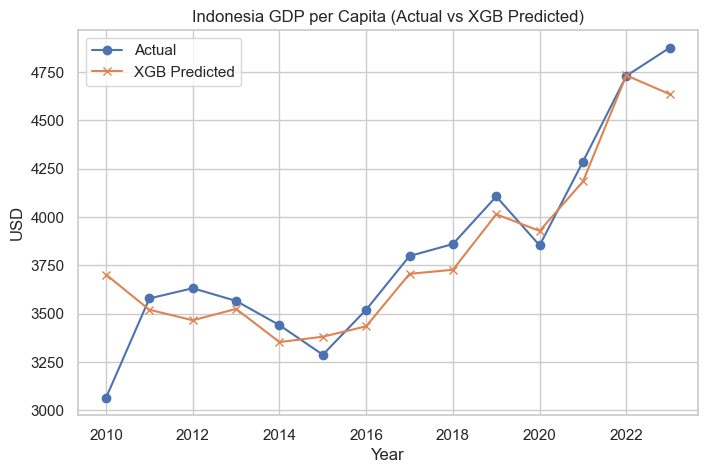

In [15]:
plt.figure(figsize=(8,5))
plt.plot(indo_full['year'], indo_full[target], label="Actual", marker="o")
plt.plot(indo_full['year'], indo_full['xgb_pred'], label="XGB Predicted", marker="x")
plt.title("Indonesia GDP per Capita (Actual vs XGB Predicted)")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.show()

# Conclusion
Here are the key takeaways from the modeling:
- SARIMAX achieved stable results with a MAPE ~5%, making it a reliable baseline for time-series forecasting.
- XGBoost delivered very strong predictive power (R² ≈ 0.96 on the test set), thanks to lagged GDP and macroeconomic indicators.
- Forecast visualizations show that both models follow the actual trend closely: SARIMAX gives smoother conservative forecasts, while XGBoost is more responsive to feature dynamics.

Overall, combining classical time series (SARIMAX) with modern ML (XGBoost) provides complementary insights: SARIMAX preserves historical consistency, while XGBoost captures complex non-linear interactions. Together, they form a robust framework for short-term economic forecasting and decision support.